# Make event semantic vectors using USE

In [26]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from scipy.spatial import distance
from scipy.stats import zscore, pearsonr, kendalltau,  entropy, spearmanr, linregress, rankdata, ttest_rel, ttest_1samp, ttest_ind, sem
import scipy.linalg as la
import itertools

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
    return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [2]:
DATADIR = '/home/jiunchoi/OFD/OFD_BHV_clean'
group = 2
sub = 1
groupsub = '0'+str(group)+'0'+str(sub)

In [ ]:
names = []
with open(f"{DATADIR}/subnames", "r") as f:
    names.extend(f.read().split('\n'))

subname = names[group-1].split()
subname = subname[1:]

data_transcript = pd.read_excel(f'{DATADIR}/group-0{str(group)}/group-0{str(group)} sharedeb.xlsx')
data_script = data_transcript['sentence']
sharedeb = np.array(data_transcript['sharedeb'])
sentence_embedding = np.array(embed(data_script))

event_semantic_vectors = np.zeros((int(sharedeb[-1]),sentence_embedding.shape[-1]))
for i in range (1,int(sharedeb[-1])+1):
    event_semantic_vectors[i-1] = np.mean(sentence_embedding[sharedeb==i,:],axis=0)

np.save(f'{DATADIR}/group-0{str(group)}/group-0{str(group)} event_semantic_vectors.npy',event_semantic_vectors)
event_semantic_vectors.shape

# Calculate event semantic similarities

In [22]:
def extract_recalledidx(group):
    keys = [f'sub-0{group}01',f'sub-0{group}02',f'sub-0{group}03']

    data_transcript = pd.read_excel(f'{DATADIR}/group-0{str(group)}/group-0{str(group)} sharedeb.xlsx')
    sharedeb = np.array(data_transcript['sharedeb'])
    data_recs = np.array(data_transcript[keys])

    notrecalled_evidx=[]
    for i in range(len(sharedeb)):
        count=0
        for j in range(3):
            if (type(data_recs[i,j])!=str and np.isnan(data_recs[i,j])==True) or (data_recs[i,j]==0):
                count+=1
        if count==3:
            if sharedeb[i] not in notrecalled_evidx:
                notrecalled_evidx.append(sharedeb[i])

    recalled_evidx=[]
    for i in range(len(sharedeb)):
        count=0
        for j in range(3):
            if (type(data_recs[i,j])==str or np.isnan(data_recs[i,j])==False) and (data_recs[i,j]!=0):
                count+=1
        if count==3:
            if sharedeb[i] not in recalled_evidx:
                recalled_evidx.append(sharedeb[i])
    return notrecalled_evidx, recalled_evidx

def cal_eventsemantics_cossim(group,recalledevidx):
    event_semantic_vectors = np.load(f'{DATADIR}/group-0{str(group)}/group-0{str(group)} event_semantic_vectors.npy')
    ev_combinations = list(itertools.combinations(recalledevidx, 2))
    shared_cossim = np.zeros(len(ev_combinations))

    for e,ec in enumerate(ev_combinations):
        pattern_1 = event_semantic_vectors[ec[0]-1, :]
        pattern_2 = event_semantic_vectors[ec[1]-1, :]
        shared_cossim[e] = distance.cosine(pattern_1, pattern_2)
    shared_cossim = np.mean(shared_cossim)
    return shared_cossim

def permut_eventsemantics_cossim(group,n_permutation=1000):
    data_transcript = pd.read_excel(f'{DATADIR}/group-0{str(group)}/group-0{str(group)} sharedeb.xlsx')
    sharedeb = np.array(data_transcript['sharedeb'])
    event_semantic_vectors = np.load(f'{DATADIR}/group-0{str(group)}/group-0{str(group)} event_semantic_vectors.npy')
    random_indices = []
    for i in range(n_permutation):
        random_indices.append(np.random.randint(1,sharedeb[-1],size=2))
    random_indices = np.array(random_indices)

    rand_cossim = np.zeros(len(random_indices))
    for e,ec in enumerate(random_indices):
        pattern_1 = event_semantic_vectors[ec[0]-1, :]
        pattern_2 = event_semantic_vectors[ec[1]-1, :]
        rand_cossim[e] = distance.cosine(pattern_1, pattern_2)
    rand_cossim = np.mean(rand_cossim)
    return rand_cossim

def cal_eventsemantics_pearsonr(group,recalledevidx):
    event_semantic_vectors = np.load(f'{DATADIR}/group-0{str(group)}/group-0{str(group)} event_semantic_vectors.npy')
    ev_combinations = list(itertools.combinations(recalledevidx, 2))
    shared_r = np.zeros(len(ev_combinations))

    for e,ec in enumerate(ev_combinations):
        pattern_1 = event_semantic_vectors[ec[0]-1, :]
        pattern_2 = event_semantic_vectors[ec[1]-1, :]
        shared_r[e] = pearsonr(pattern_1, pattern_2)[0]
    shared_r = np.mean(shared_r)
    return shared_r

def permut_eventsemantics_pearsonr(group,n_permutation=1000):
    data_transcript = pd.read_excel(f'{DATADIR}/group-0{str(group)}/group-0{str(group)} sharedeb.xlsx')
    sharedeb = np.array(data_transcript['sharedeb'])
    event_semantic_vectors = np.load(f'{DATADIR}/group-0{str(group)}/group-0{str(group)} event_semantic_vectors.npy')
    random_indices = []
    for i in range(n_permutation):
        random_indices.append(np.random.randint(1,sharedeb[-1],size=2))
    random_indices = np.array(random_indices)

    rand_r = np.zeros(len(random_indices))
    for e,ec in enumerate(random_indices):
        pattern_1 = event_semantic_vectors[ec[0]-1, :]
        pattern_2 = event_semantic_vectors[ec[1]-1, :]
        rand_r[e] = pearsonr(pattern_1, pattern_2)[0]
    rand_r = np.mean(rand_r)
    return rand_r

In [23]:
groups=[2,3,4,5]
cossims = np.zeros((len(groups),3))

for i,group in enumerate(groups):
    notrecalled_evidx,recalledevidx = extract_recalledidx(group)
    cossims[i,0] = cal_eventsemantics_cossim(group,recalledevidx)
    cossims[i,1] = cal_eventsemantics_cossim(group,notrecalled_evidx)
    cossims[i,2] = permut_eventsemantics_cossim(group,n_permutation=1000)

corrs = np.zeros((len(groups),3))
for i,group in enumerate(groups):
    notrecalled_evidx,recalledevidx = extract_recalledidx(group)
    corrs[i,0] = cal_eventsemantics_pearsonr(group,recalledevidx)
    corrs[i,1] = cal_eventsemantics_pearsonr(group,notrecalled_evidx)
    corrs[i,2] = permut_eventsemantics_pearsonr(group,n_permutation=1000)

In [24]:
cossims

array([[0.2931222 , 0.33689931, 0.30811795],
       [0.34696726, 0.33002417, 0.34977919],
       [0.23856012, 0.27563418, 0.28562875],
       [0.35271783, 0.35173615, 0.37086439]])

Ttest_relResult(statistic=-2.2143151442114135, pvalue=0.11364342564100868)
Ttest_relResult(statistic=-0.4373702433163396, pvalue=0.6914147360943057)


Text(0.5, 1.0, 'event semantic\n similarity')

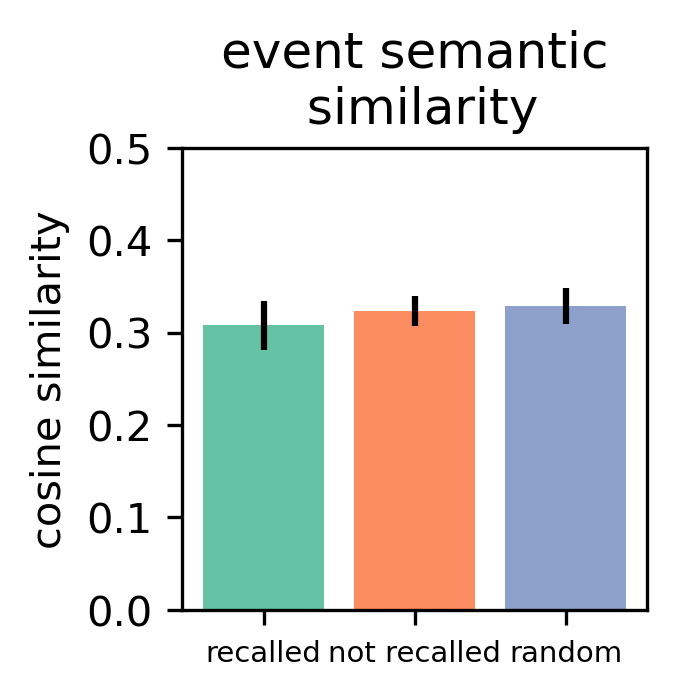

In [38]:
colors = sns.color_palette("Set2")
print(ttest_rel(cossims[:,0], cossims[:,2]))
print(ttest_rel(cossims[:,1], cossims[:,2]))
plt.figure(figsize=(2,2), dpi=300)
plt.bar([0,1,2], [np.mean(cossims[:,0]), np.mean(cossims[:,1]), np.mean(cossims[:,2])], yerr=[sem(cossims[:,0]), sem(cossims[:,1]), sem(cossims[:,2])], color=[colors[0], colors[1], colors[2]])
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.xticks([0,1,2], ["recalled", "not recalled", "random"],fontsize=7)
plt.ylim(None, 0.5)
plt.ylabel('cosine similarity')
plt.title('event semantic\n similarity')


Ttest_relResult(statistic=2.4897763900310883, pvalue=0.08850155378742491)
Ttest_relResult(statistic=0.4674589092822905, pvalue=0.6720320810629605)


Text(0.5, 1.0, 'event semantic\n similarity')

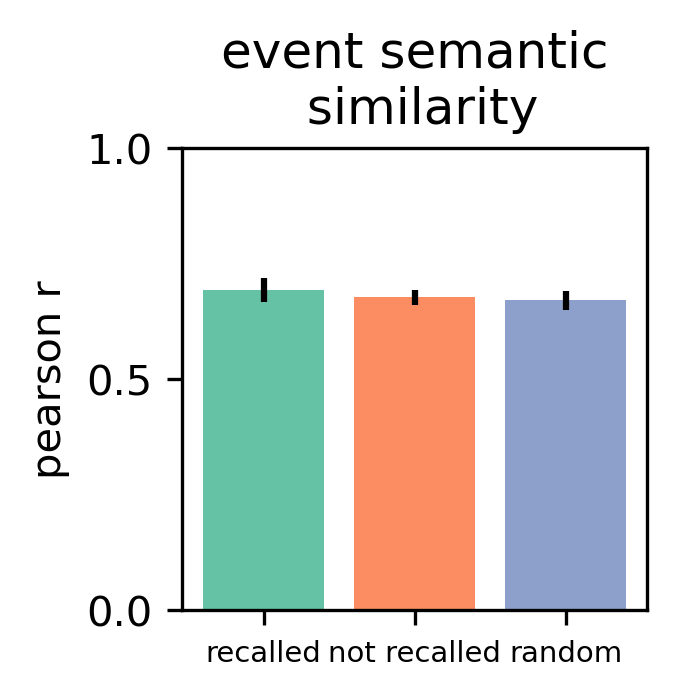

In [39]:
colors = sns.color_palette("Set2")
print(ttest_rel(corrs[:,0], corrs[:,2]))
print(ttest_rel(corrs[:,1], corrs[:,2]))

plt.figure(figsize=(2,2), dpi=300)
plt.bar([0,1,2], [np.mean(corrs[:,0]), np.mean(corrs[:,1]), np.mean(corrs[:,2])], yerr=[sem(corrs[:,0]), sem(corrs[:,1]), sem(corrs[:,2])], color=[colors[0], colors[1], colors[2]])
plt.xticks([0,1,2], ["recalled", "not recalled", "random"],fontsize=7)
plt.ylim(None, 1)
plt.yticks([0.0, 0.5,1])
plt.ylabel('pearson r')
plt.title('event semantic\n similarity')
